In [1]:
import os

while "src" not in os.listdir():
    assert "/" != os.getcwd(), "src directory not found"
    os.chdir("..")

import sys
sys.path.append('simclr-pytorch')

import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

import torch
from torch.utils.data import DataLoader, random_split

from src.lib.nyu_dataset import NYUDataset, transform
from src.lib.util import convert_depth_to_m

In [2]:
DATA_DIR = "data"
DATASET_FILE = "nyu_depth_v2_labeled.mat"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dataset = NYUDataset(os.path.join(DATA_DIR, DATASET_FILE), transform=lambda x, y: transform(x, y, seed=0))

n_train, n_val = int(0.8 * len(dataset)), int(0.1 * len(dataset))
n_test = len(dataset) - n_train - n_val

train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(test_set, batch_size=7, shuffle=False, num_workers=8)

In [4]:
experiments_dir = "experiments"
experiment_names = list(filter(lambda name: name[-1] == "0", os.listdir(experiments_dir)))
print(experiment_names)

models_map = {}
for name in experiment_names:
    model_path = os.path.join(experiments_dir, name, "model.pth")
    models_map[name] = {"model": torch.load(model_path).to("cpu")}
    

['contrastive_switch_bs64_lr0.0001_epochs70_dropout0.0_0', 'contrastive_probing_bs64_lr0.0001_epochs70_dropout0.0_0', 'classification_switch_bs64_lr0.0001_epochs70_dropout0.0_0', 'classification_probing_bs64_lr0.0001_epochs70_dropout0.0_0', 'contrastive_finetuning_bs64_lr0.0001_epochs70_dropout0.0_0', 'classification_finetuning_bs64_lr0.0001_epochs70_dropout0.0_0']


In [7]:
images = {}
# name: [numpy array image] (n_images, H, W, n_channels)
for name in models_map:
    model = models_map[name]["model"].to(device)
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            images["RGB"] = x.numpy().transpose(0, 2, 3, 1)
            images["depth"] = y.numpy().transpose(0, 2, 3, 1)

            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            images[name] = y_pred.to("cpu").numpy().transpose(0, 2, 3, 1)
            # images[name] = x.to("cpu").numpy().transpose(0, 2, 3, 1)
            break

    model.to("cpu")
    del x, y, y_pred
    torch.cuda.empty_cache()


[(0, 'input'), (1, 'ground\ntruth'), (2, 'contrastive\nswitch'), (3, 'contrastive\nprobing'), (4, 'classification\nswitch'), (5, 'classification\nprobing'), (6, 'contrastive\nfinetuning'), (7, 'classification\nfinetuning')]


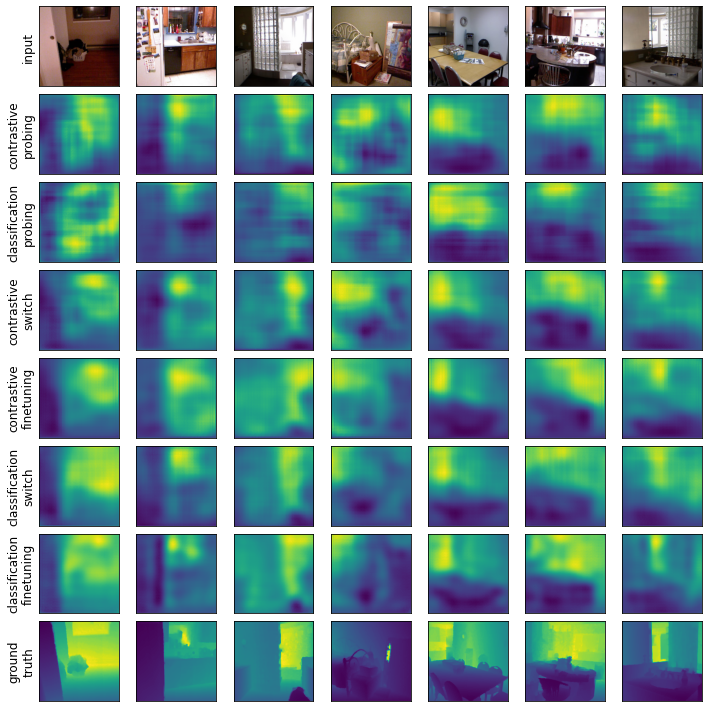

In [39]:
# make a plot of the images RGB, predicted depths, and ground truth depths in an 8x7 grid
import matplotlib.pyplot as plt

names = list(images)
labels = ["input", "ground\ntruth"] + ["\n".join(name.split("_")[:2]) for name in names[2:]]

print(list(enumerate(labels)))

fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(10, 10))

order = [0, 3, 5, 2, 6, 4, 7, 1] # this is the order the things are in the table

for i, ax in enumerate(axes[:, 0]):
    ax.set_ylabel(labels[order[i]], size="large")

for i, ax in enumerate(axes[:, 0]):
    for j in range(7):
        ax = axes[i][j]
        # remove tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(images[names[order[i]]][j])

fig.tight_layout()
# make background white
# fig.patch.set_facecolor("white")

# reduce vertical space between rows
fig.subplots_adjust(hspace=0.1)
# reduce horizontal space between columns
fig.subplots_adjust(wspace=0.1)
fig.savefig("results/example_predictions.png")
fig.show()  


In [ ]:

thresholds = [1.25, 1.25**2, 1.25**3]

mean_stats = defaultdict(lambda : defaultdict(list))
for name in stats:
    base_name = " ".join(name.split("_")[:2])
    mean_stats[base_name]["test_loss"].append(stats[name]["test_loss"])
    mean_stats[base_name]["test_rel"].append(np.mean(stats[name]["test_rel"]))

    errors = stats[name]["test_errors"]
    for threshold in thresholds:
        mean_stats[base_name][f"test_acc_{threshold}"].append(np.mean(errors < threshold))

for name in mean_stats:
    mean_stats[name]["test_errors"] = np.mean(mean_stats[name]["test_errors"])
    mean_stats[name]["test_rel"] = np.mean(mean_stats[name]["test_rel"])
    mean_stats[name]["test_loss"] = np.mean(mean_stats[name]["test_loss"])
    for threshold in thresholds:
        mean_stats[name][f"test_acc_{threshold}"] = np.mean(mean_stats[name][f"test_acc_{threshold}"])


for name in sorted(mean_stats):
    print(f"test_loss\t{name}:\t{mean_stats[name]['test_loss']:.4f}")
    print(f"test_rel\t{name}:\t{mean_stats[name]['test_rel']:.4f}")
    for threshold in thresholds:
        key = f"test_acc_{threshold}"
        print(f"{key}\t{name}:\t{mean_stats[name][key]:.4f}")

In [ ]:
import pandas as pd 
df = pd.DataFrame(mean_stats).T
# drop col test_errors
df = df.drop("test_errors", axis=1)
df.columns = ["loss", "rel", "delta leq 1.25", "delta leq 1.25^2", "delta leq 1.25^3"]
# sort by rel desc
df = df.sort_values("rel", ascending=False)
# print in latex with 3 decimal places
print(df.to_latex(index=True, float_format="%.3f"))